In [1]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools 
import collections 
from copy import copy

In [2]:
class DynamicProgramming: #名前を変更 ###dynamicprogramming
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes]))
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def value_iteration_sweep(self): #追加
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                max_q = -1e100
                max_a = None
                qs = [self.action_value(a, index) for a in self.actions] #全行動の行動価値を計算
                max_q = max(qs)                               #最大の行動価値
                max_a = self.actions[np.argmax(qs)]   #最大の行動価値を与える行動
                
                delta = abs(self.value_function[index] - max_q)            #変化量
                max_delta = delta if delta > max_delta else max_delta #スイープ中で最大の変化量の更新
                
                self.value_function[index] = max_q      #価値の更新
                self.policy[index] = np.array(max_a).T  #方策の更新
            
        return max_delta        
        
    def policy_evaluation_sweep(self):   
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                
                delta = abs(self.value_function[index] - q)
                max_delta = delta if delta > max_delta else max_delta
                
                self.value_function[index] = q
            
        return max_delta
    
    def action_value(self, action, index): #はみ出しペナルティー追加
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]: 
            after, edge_reward = self.edge_correction(np.array(index).T + delta)
            after = tuple(after)
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + edge_reward
            value += (self.value_function[after] + reward) * prob

        return value
            
    def edge_correction(self, index): #変更
        edge_reward = 0.0
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #方角の処理
        
        for i in range(2):
            if index[i] < 0:
                index[i] = 0
                edge_reward = -1e100
            elif index[i] >= self.index_nums[i]:
                index[i] = self.index_nums[i]-1
                edge_reward = -1e100
                
        return index, edge_reward
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**3点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0, i_t]).T                                                      #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**3 for c in count]                   #サンプル数で割って確率にする
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return sum([self.goal.inside(np.array(c).T) for c in corners ]) == 4 #全部goal.insideがTrueならsumが4に

In [3]:
import seaborn as sns   ###dp1exec

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 

###制御の周期を0.3秒ごとに。水たまりの罰を増やす###
dp = DynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.3, 10) 

counter = 0 #スイープの回数

In [4]:
delta = 1e100

#while delta > 0.01:  #最後まで計算するとき
for i in range(10):
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)

1 33.0850354828
2 21.7392011476
3 16.5444990534
4 15.5020947635
5 14.1534381526
6 12.8663455546
7 12.2159607379
8 11.3820283345
9 10.6858114218
10 9.83882809753


<IPython.core.display.Javascript object>


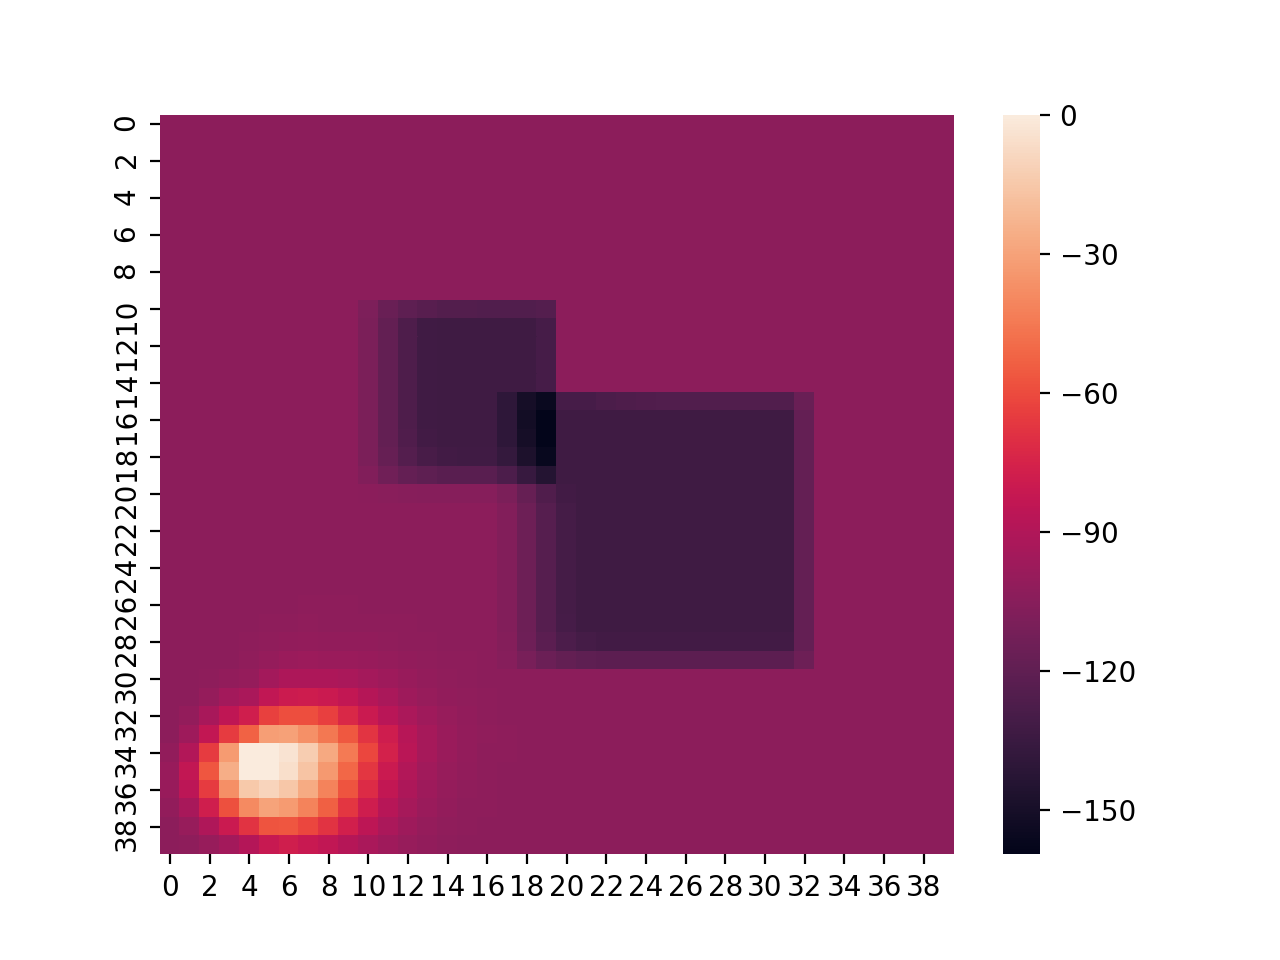

In [5]:
v = dp.value_function[:, :, 18]
sns.heatmap(np.rot90(v), square=False)
plt.show()

{(0.20000000000000001, 0.0): 0, (0.0, 0.5): 1, (0.0, -0.5): 2}


<IPython.core.display.Javascript object>


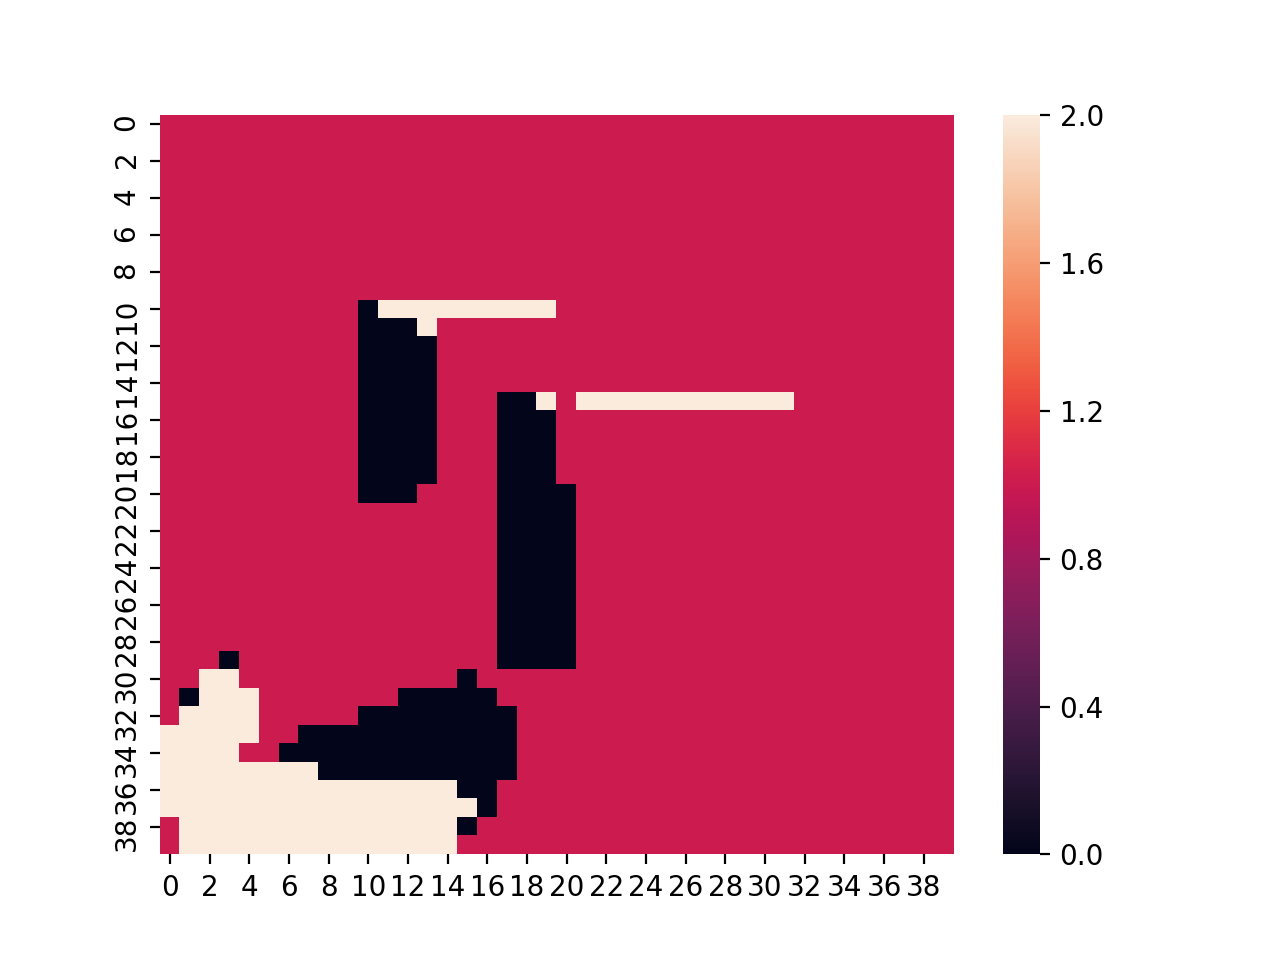

In [6]:
action_to_indexes = {}
for i, a in enumerate(dp.actions):
    action_to_indexes[tuple(a)] = i

policy = np.zeros(dp.index_nums)
for i in dp.indexes:
    policy[i] = action_to_indexes[tuple(dp.policy[i])]

print(action_to_indexes)

p = policy[:, :, 18]
sns.heatmap(np.rot90(p), square=False)
plt.show()